In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Mon Jan 22 02:45:35 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   50C    P0    74W / 300W |   8265MiB / 80994MiB |     22%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -1
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.99

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_0.99_-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

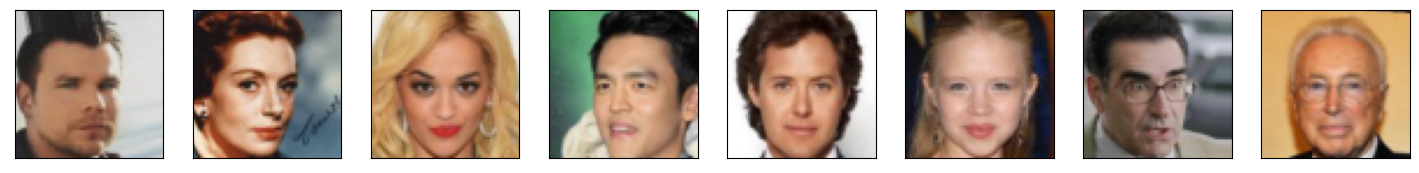

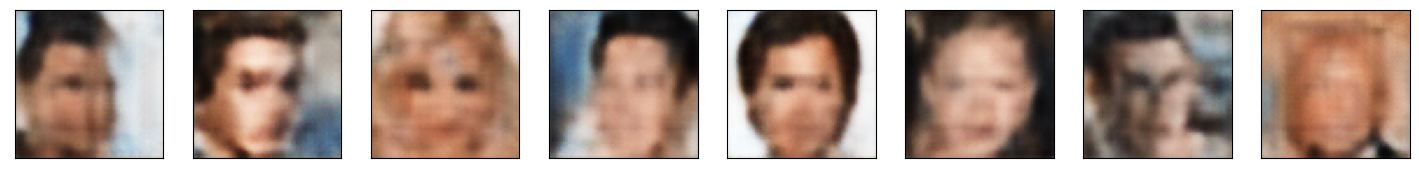

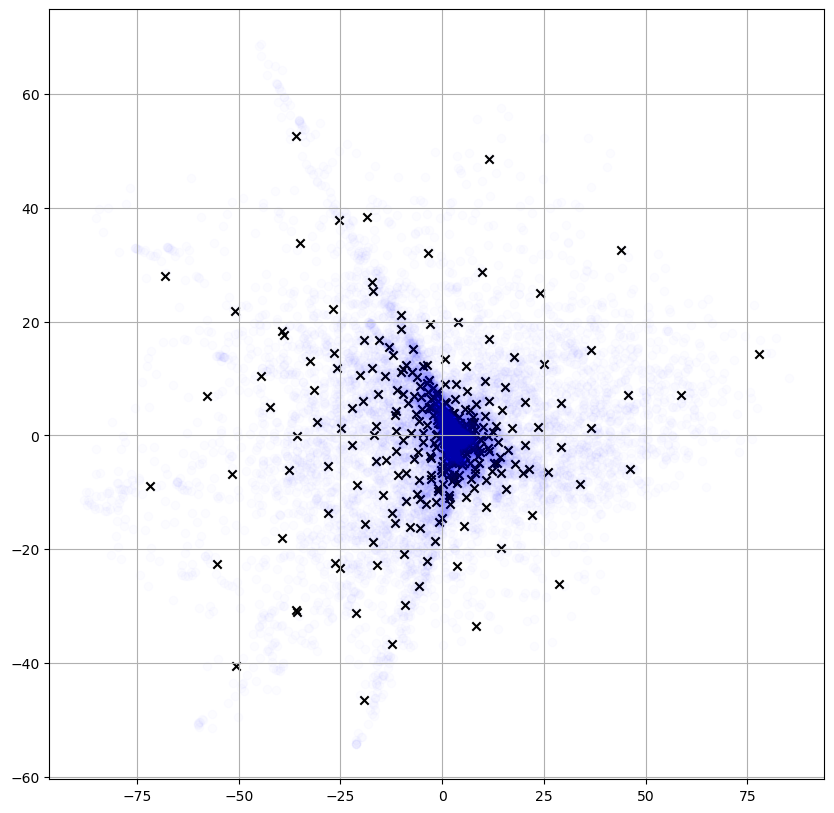

3001
lse_loss -85.41932678222656
commit_loss 0.15511702001094818
recon_loss 0.008266562595963478
3002
lse_loss -85.403564453125
commit_loss 0.17229685187339783
recon_loss 0.00802541896700859
3003
lse_loss -84.68345642089844
commit_loss 0.17427867650985718
recon_loss 0.008516665548086166
3004
lse_loss -85.54029083251953
commit_loss 0.15437960624694824
recon_loss 0.008511258289217949
3005
lse_loss -85.2239761352539
commit_loss 0.18002864718437195
recon_loss 0.00858396664261818
3006
lse_loss -85.32196807861328
commit_loss 0.17808008193969727
recon_loss 0.008261134847998619
3007
lse_loss -86.00736236572266
commit_loss 0.174570232629776
recon_loss 0.008194630034267902
3008
lse_loss -85.79142761230469
commit_loss 0.15730269253253937
recon_loss 0.008019511587917805
3009
lse_loss -85.8807144165039
commit_loss 0.14715318381786346
recon_loss 0.007985158823430538
3010
lse_loss -84.28559875488281
commit_loss 0.18786382675170898
recon_loss 0.00826992280781269
3011
lse_loss -85.61236572265625
commit

3088
lse_loss -84.72802734375
commit_loss 0.18549907207489014
recon_loss 0.008838163688778877
3089
lse_loss -86.1917953491211
commit_loss 0.19766616821289062
recon_loss 0.008840091526508331
3090
lse_loss -85.5854721069336
commit_loss 0.14936059713363647
recon_loss 0.008839081972837448
3091
lse_loss -85.6756820678711
commit_loss 0.1764068603515625
recon_loss 0.008422773331403732
3092
lse_loss -86.38401794433594
commit_loss 0.17724336683750153
recon_loss 0.008482784032821655
3093
lse_loss -86.41783142089844
commit_loss 0.1603526473045349
recon_loss 0.008614661172032356
3094
lse_loss -86.25402069091797
commit_loss 0.16509616374969482
recon_loss 0.008920153602957726
3095
lse_loss -86.48131561279297
commit_loss 0.16347923874855042
recon_loss 0.009636646136641502
3096
lse_loss -86.51553344726562
commit_loss 0.16171063482761383
recon_loss 0.008516146801412106
3097
lse_loss -86.05838012695312
commit_loss 0.1751137673854828
recon_loss 0.008852283470332623
3098
lse_loss -86.72486114501953
commit

lse_loss -86.67066192626953
commit_loss 0.18683266639709473
recon_loss 0.00844434555619955
3175
lse_loss -87.04306030273438
commit_loss 0.14934104681015015
recon_loss 0.009149903431534767
3176
lse_loss -87.19097137451172
commit_loss 0.14959987998008728
recon_loss 0.009227432310581207
3177
lse_loss -87.27976989746094
commit_loss 0.16828373074531555
recon_loss 0.008471246808767319
3178
lse_loss -86.97172546386719
commit_loss 0.16753049194812775
recon_loss 0.010260775685310364
3179
lse_loss -87.06776428222656
commit_loss 0.17806756496429443
recon_loss 0.008026251569390297
3180
lse_loss -86.3631591796875
commit_loss 0.15864840149879456
recon_loss 0.009657515212893486
3181
lse_loss -87.0879135131836
commit_loss 0.14564773440361023
recon_loss 0.008774969726800919
3182
lse_loss -87.5539779663086
commit_loss 0.1653347909450531
recon_loss 0.008602071553468704
3183
lse_loss -87.59000396728516
commit_loss 0.15952126681804657
recon_loss 0.008168818429112434
3184
lse_loss -87.370849609375
commit_lo

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')